In [73]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [74]:
dfGb= pd.read_csv("../../our_data/Etap3/dfGB_merged.csv")

dfUS = pd.read_csv("../../our_data/Etap3/dfUS_merged.csv")

In [3]:
dfGb.shape

(3245, 105)

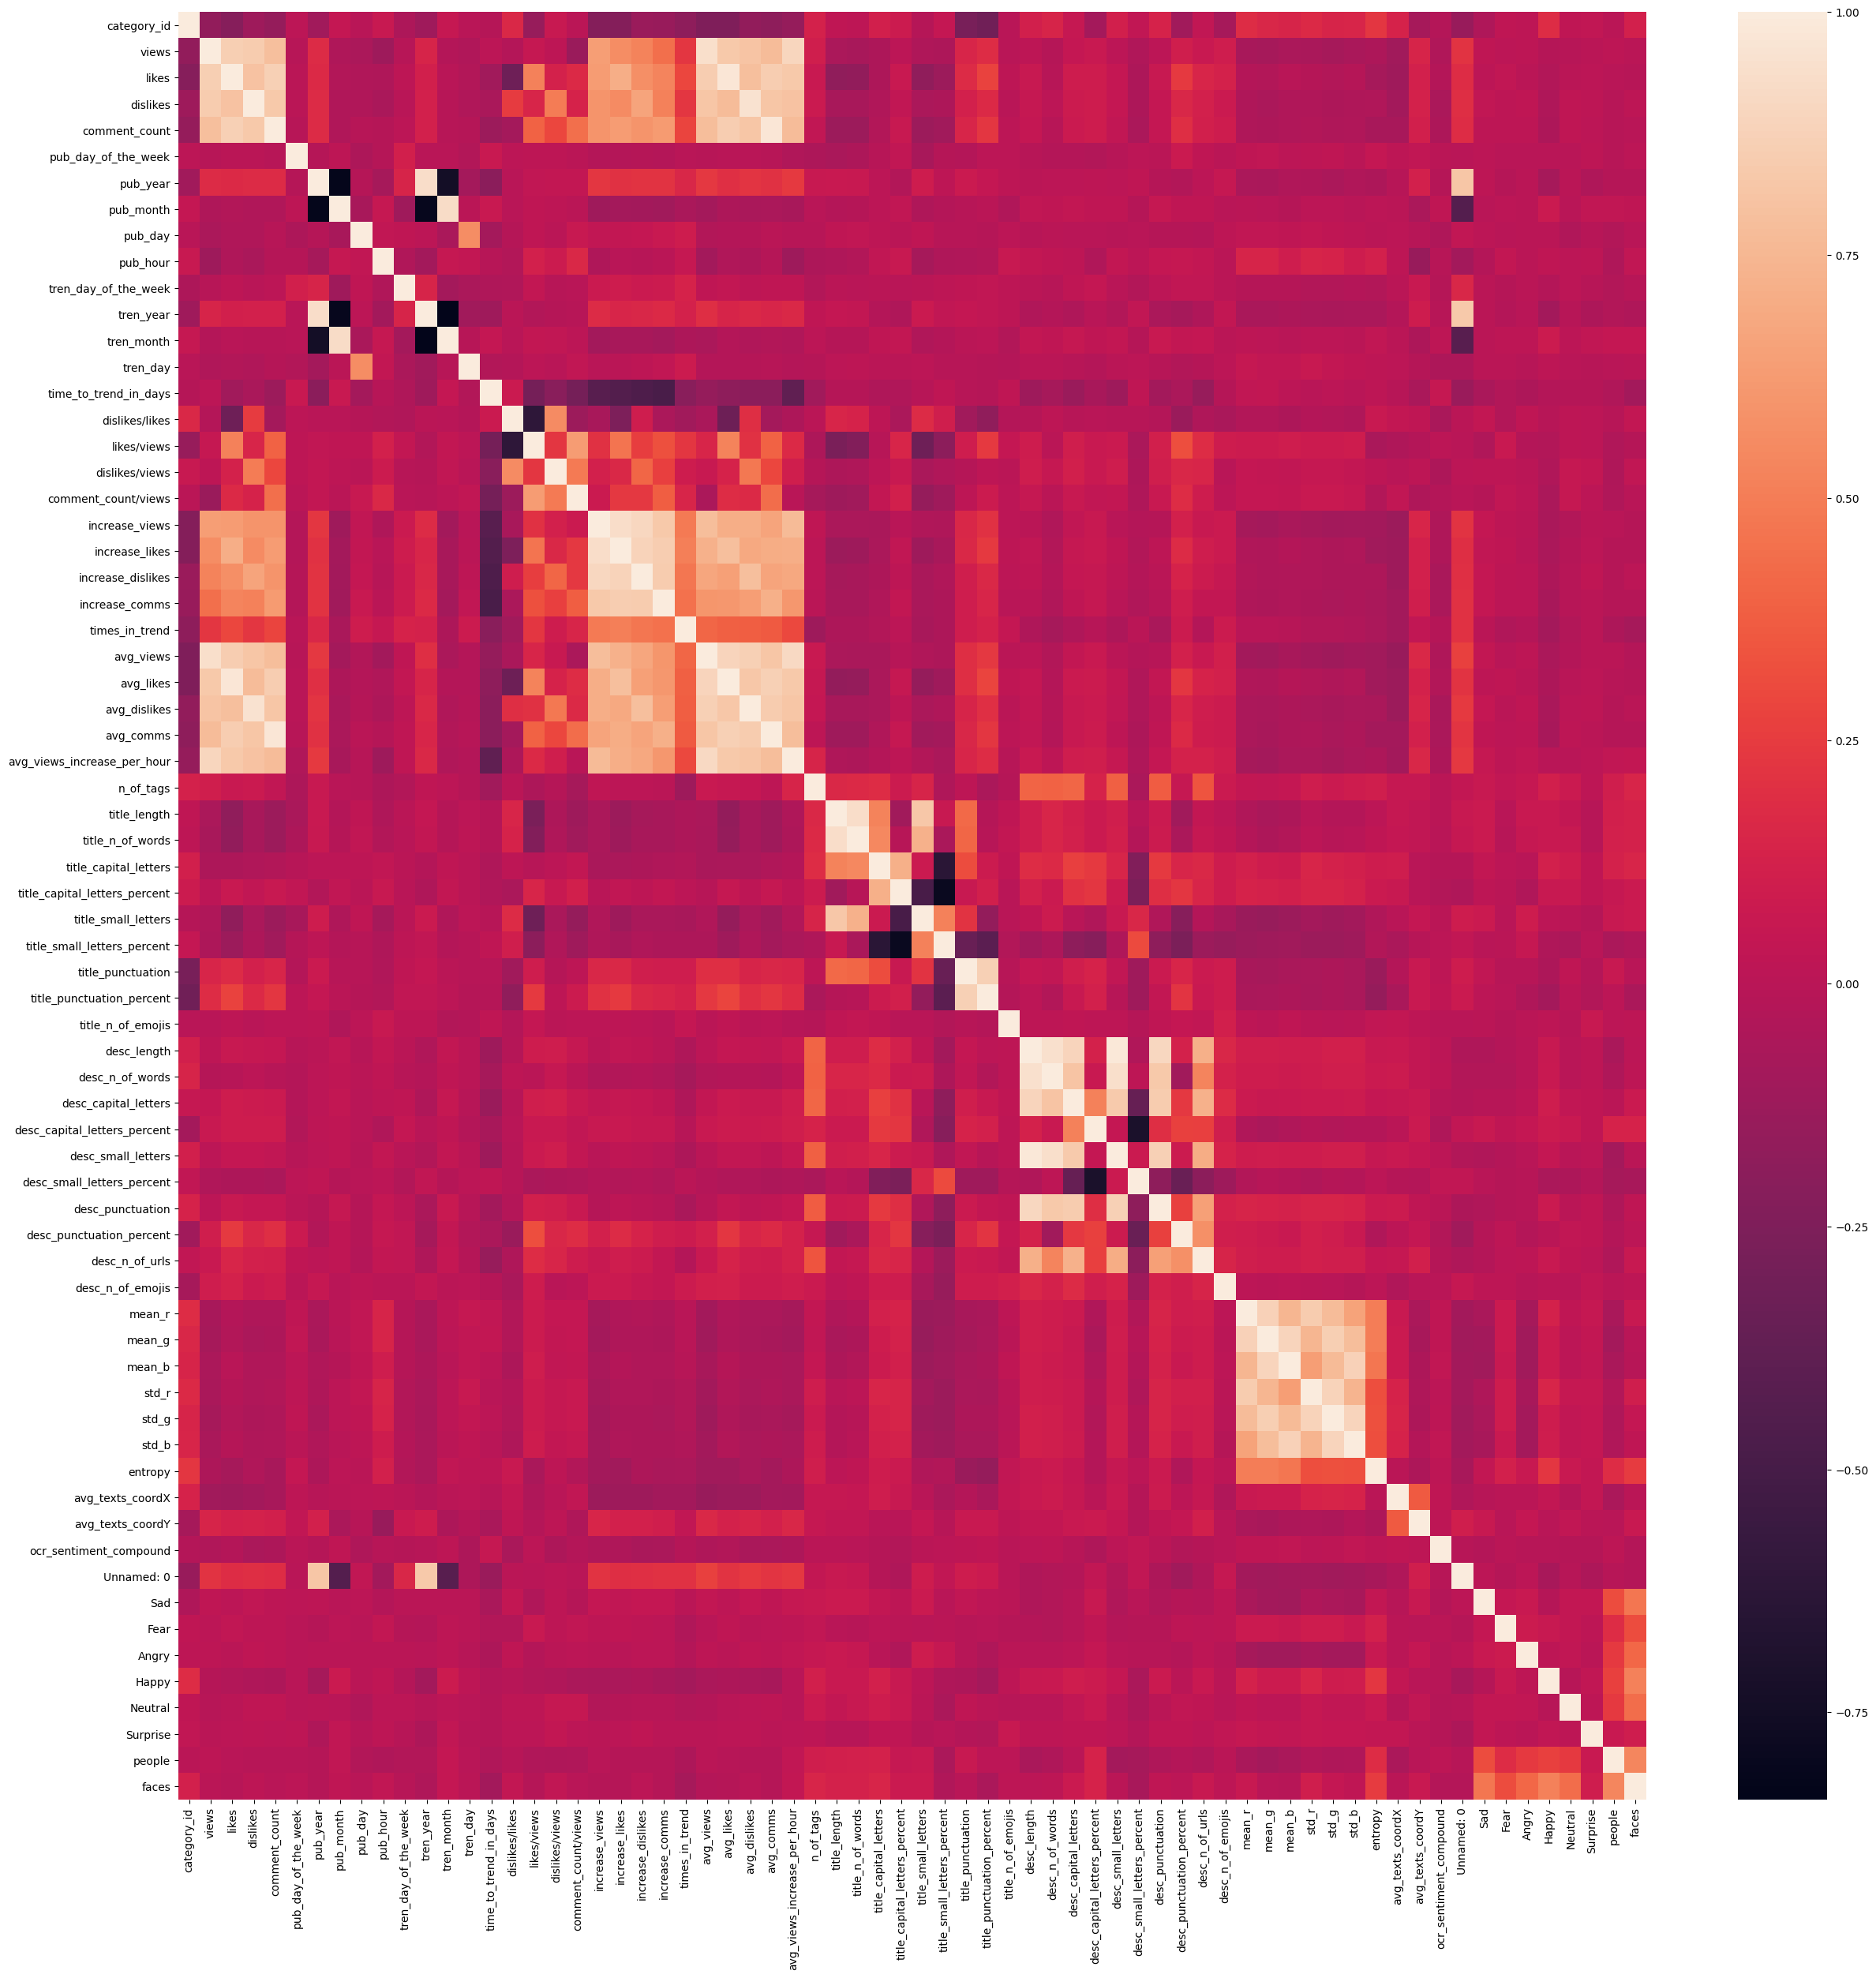

In [19]:
corr = dfGb.corr(method='spearman')
plt.figure(figsize=(30,30),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanGB.pdf")
plt.show()

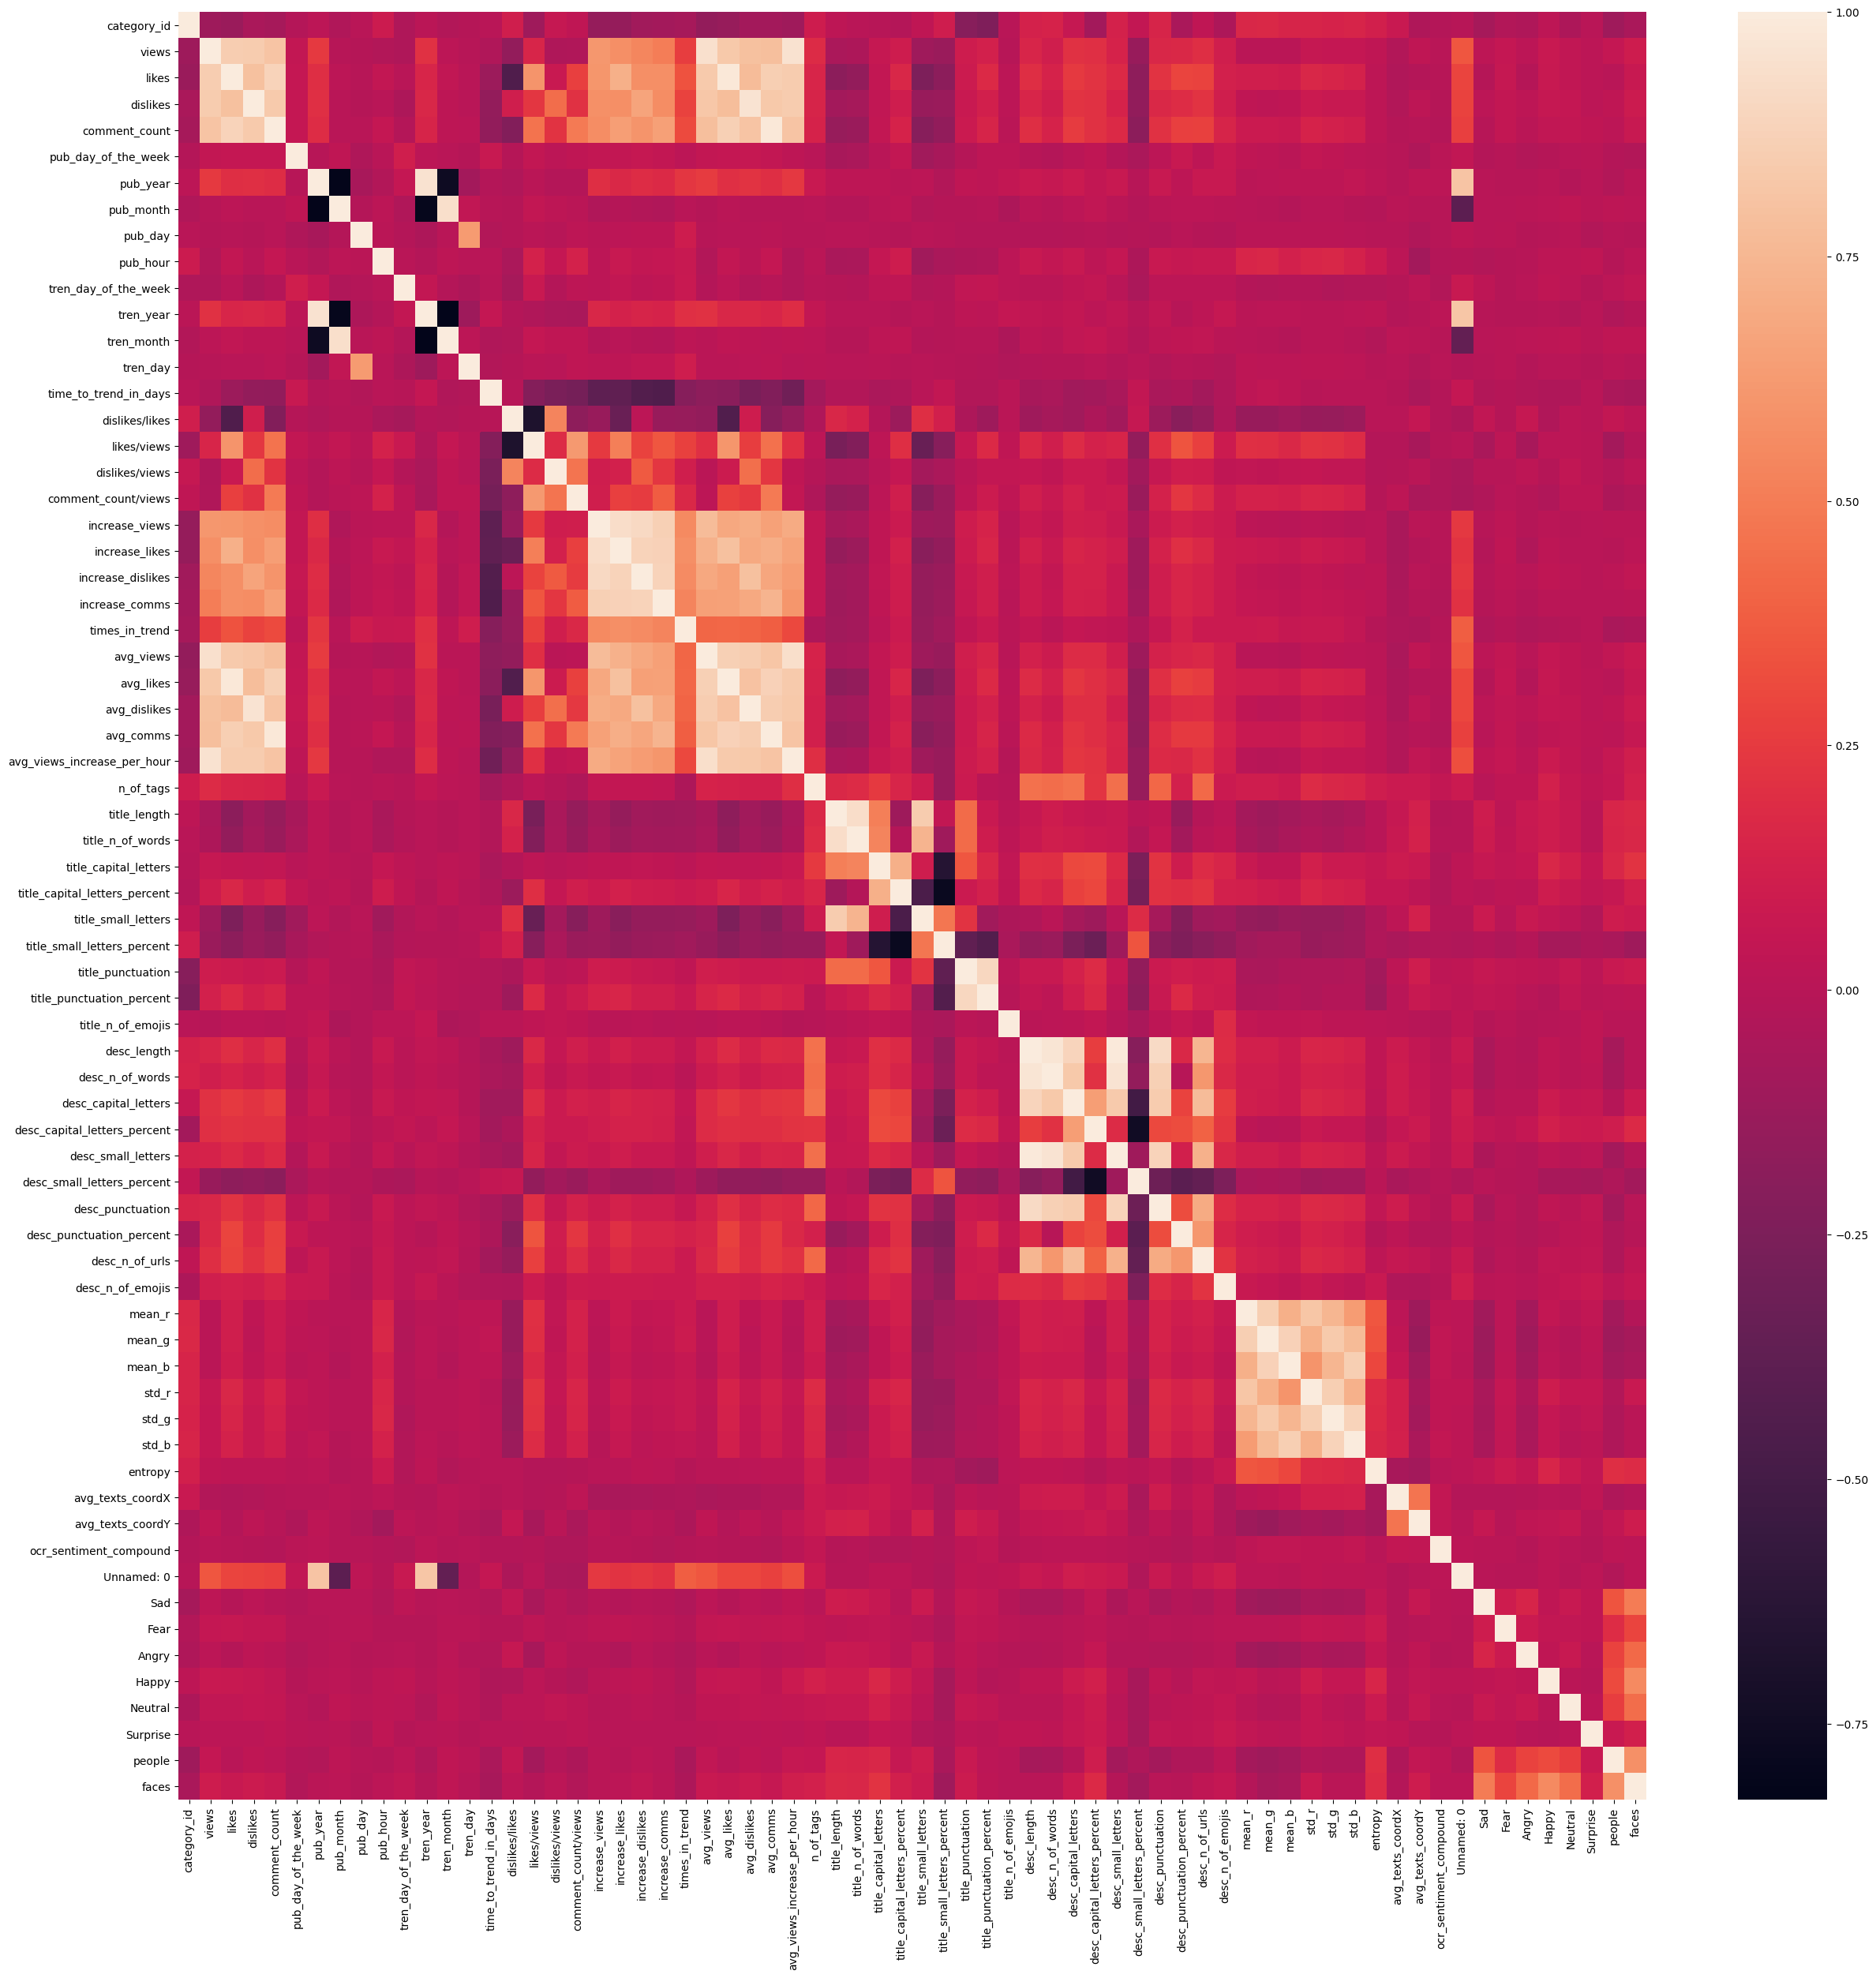

In [18]:
corr = dfUS.corr(method='spearman')
plt.figure(figsize=(30,30),dpi=100)
sns.heatmap(corr)
plt.savefig("../../our_data/Etap3/corr_spearmanUS.pdf")
plt.show()

In [47]:
dfUSnew = dfUS[ dfUS['category_id'].notna() ]
y = dfUSnew.loc[:,'category_id']
X  = dfUSnew.loc[:, dfUSnew.columns != 'category_id']
X = X.select_dtypes(include=np.number)
X = X.fillna(-1)
# y
# print(selection)
# dfUS.columns
# len(X)

Feature ranking:
1. feature likes/views (0.033085)
2. feature n_of_tags (0.024351)
3. feature avg_texts_coordY (0.022195)
4. feature title_punctuation_percent (0.021956)
5. feature title_capital_letters_percent (0.021463)
6. feature desc_punctuation_percent (0.021397)
7. feature desc_n_of_urls (0.021003)
8. feature pub_hour (0.020549)
9. feature title_small_letters_percent (0.020466)
10. feature desc_capital_letters_percent (0.019298)
11. feature desc_n_of_words (0.019270)
12. feature title_capital_letters (0.019225)
13. feature title_punctuation (0.019194)
14. feature desc_capital_letters (0.019012)
15. feature mean_r (0.018852)
16. feature desc_small_letters_percent (0.018850)
17. feature title_length (0.018712)
18. feature desc_punctuation (0.018709)
19. feature desc_length (0.018644)
20. feature desc_small_letters (0.018380)
21. feature title_small_letters (0.018196)
22. feature avg_texts_coordX (0.017834)
23. feature comment_count/views (0.017182)
24. feature std_r (0.017093)
25. 

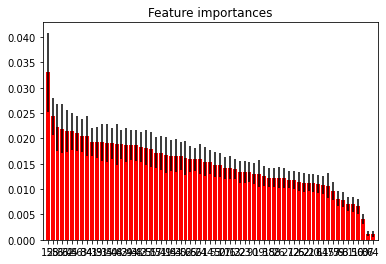

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# # Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# X = 
# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [76]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

clf = BaggingClassifier(DecisionTreeClassifier())
clf.fit(X, y)

feature_importances = np.mean([
    tree.feature_importances_ for tree in clf.estimators_
], axis=0)

df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
df.sort_values(by=0,ascending=False)

,0,1
15,0.0522182,likes/views
56,0.0516386,avg_texts_coordY
32,0.0367237,title_capital_letters_percent
17,0.0308779,comment_count/views
28,0.0290749,n_of_tags
...,...,...
5,0.00115257,pub_year
10,0.000935678,tren_year
60,0.000824773,Fear
37,0.00028629,title_n_of_emojis


In [45]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# X, y = load_iris(return_X_y=True)
X.shape

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]

X_new.shape

print(feature_name)

Index(['likes', 'dislikes', 'comment_count', 'pub_day_of_the_week', 'pub_year',
       'pub_month', 'pub_day', 'pub_hour', 'tren_day_of_the_week', 'tren_year',
       'tren_month', 'tren_day', 'time_to_trend_in_days', 'dislikes/likes',
       'increase_likes', 'increase_dislikes', 'increase_comms',
       'times_in_trend', 'avg_likes', 'avg_dislikes', 'avg_comms', 'n_of_tags',
       'title_length', 'title_n_of_words', 'title_capital_letters',
       'title_small_letters', 'title_punctuation', 'desc_length',
       'desc_n_of_words', 'desc_capital_letters', 'desc_small_letters',
       'desc_punctuation', 'desc_n_of_urls', 'desc_n_of_emojis', 'mean_r',
       'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b', 'entropy',
       'avg_texts_coordX', 'avg_texts_coordY', 'Unnamed: 0', 'Sad', 'Happy',
       'people', 'faces'],
      dtype='object')


/home/adam/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [43]:
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,21.0,8.0,64.0,6.0,2017.0,11.0,12.0,15.0,1.0,2017.0,...,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
1,420.0,10.0,236.0,4.0,2017.0,11.0,10.0,4.0,1.0,2017.0,...,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
2,1603.0,239.0,397.0,2.0,2017.0,11.0,22.0,8.0,3.0,2017.0,...,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
3,56.0,35.0,107.0,0.0,2017.0,11.0,27.0,3.0,1.0,2017.0,...,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
4,1393.0,46.0,120.0,2.0,2017.0,11.0,29.0,10.0,3.0,2017.0,...,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819,26166.0,895.0,3517.0,1.0,2018.0,6.0,12.0,18.0,3.0,2018.0,...,89.540707,81.249280,6.783032,66.25,251.250000,5797.0,0.0,0.0,4.0,1.0
5820,7701.0,320.0,2505.0,2.0,2018.0,6.0,13.0,15.0,3.0,2018.0,...,65.411258,65.868185,6.518317,238.75,259.000000,5798.0,1.0,0.0,3.0,2.0
5821,18811.0,399.0,1074.0,2.0,2018.0,6.0,13.0,5.0,3.0,2018.0,...,59.167768,66.713422,6.490607,128.70,261.100000,5799.0,1.0,0.0,6.0,4.0
5822,14206.0,693.0,1211.0,1.0,2018.0,6.0,12.0,16.0,3.0,2018.0,...,86.696468,89.276421,6.807644,234.20,157.300000,5800.0,0.0,0.0,3.0,1.0


In [48]:
# from sklearn.datasets import load_iris
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# print(X.shape)
# X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
# X_new.shape


              0                              1
26  1.46493e-05                      avg_comms
1   9.78476e-06                          likes
27  1.36037e-06    avg_views_increase_per_hour
18  7.78074e-07                 increase_views
23  2.39119e-07                      avg_views
..          ...                            ...
29            0                   title_length
30            0               title_n_of_words
31            0          title_capital_letters
32            0  title_capital_letters_percent
66            0                          faces

[67 rows x 2 columns]


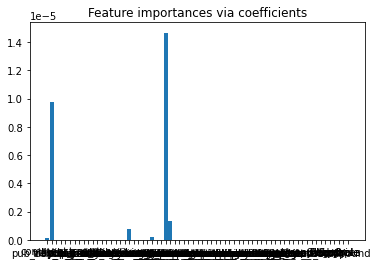

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X.columns)

df = pd.DataFrame(np.dstack([importance,X.columns])[0])
print(df.sort_values(by=0,ascending=False))

plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [67]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-15] + 0.0000001

tic = time()
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['views' 'likes' 'increase_views' 'avg_views' 'avg_comms'
 'avg_views_increase_per_hour']
Done in 0.176s


In [72]:
from sklearn.feature_selection import SequentialFeatureSelector


ImportError: cannot import name 'SequentialFeatureSelector' from 'sklearn.feature_selection' (/home/adam/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/__init__.py)

In [69]:

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(lasso, n_features_to_select=2,
                                        direction='forward').fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(lasso, n_features_to_select=2,
                                         direction='backward').fit(X, y)
toc_bwd = time()

print("Features selected by forward sequential selection: "
      f"{feature_names[sfs_forward.get_support()]}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "
      f"{feature_names[sfs_backward.get_support()]}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

ImportError: cannot import name 'SequentialFeatureSelector' from 'sklearn.feature_selection' (/home/adam/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/__init__.py)